# [《100天成为风控专家》](https://app7hmmvkwr2019.h5.xiaoeknow.com/p/course/ecourse/course_2ZAoFMNREbOv3DutKsoIi9Vlfky) 规则篇-基于决策树生成规则(3)：决策树规则自动挖掘

In [46]:
import pandas as pd
import numpy as np
import scorecardpy as sc
from sklearn import tree
from sklearn.tree import _tree
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pydotplus
import graphviz
import seaborn as sns
from matplotlib import pyplot as plt
import os, re
%matplotlib inline
## 设置属性防止中文乱码
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings("ignore")

# 0.前期准备
- 第一步：安装GraphViz软件，https://graphviz.org/download/
- 第二步：安装graphviz： pip install graphviz
- 第三步：安装pydotplus: pip install pydotplus

# 1.数据探索

In [47]:
df = pd.read_csv('lending_club_loan_two.csv')
df.shape

(396030, 27)

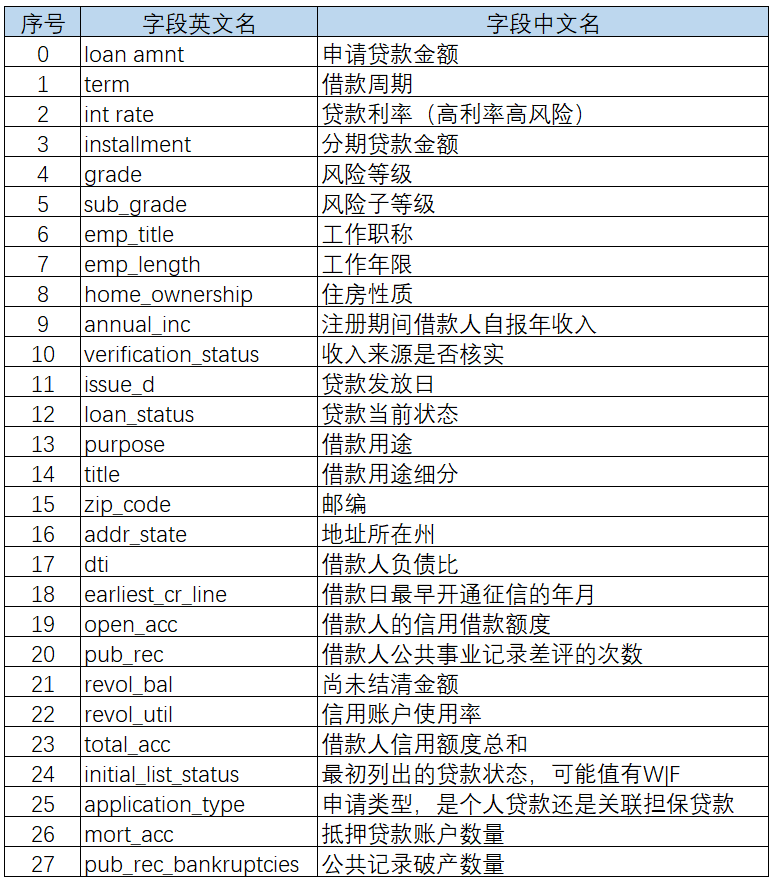

In [48]:
df.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
count,396030.0000,396030.0000,396030.0000,396030.0000,396030.0000,396030.0000,396030.0000,396030.0000,395754.0000,396030.0000,358235.0000,395495.0000
mean,14113.8881,13.6394,431.8497,74203.1758,17.3795,11.3112,0.1782,15844.5399,53.7917,25.4147,1.8140,0.1216
std,8357.4413,4.4722,250.7278,61637.6212,18.0191,5.1376,0.5307,20591.8361,24.4522,11.8870,2.1479,0.3562
min,500.0000,5.3200,16.0800,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000
25%,8000.0000,10.4900,250.3300,45000.0000,11.2800,8.0000,0.0000,6025.0000,35.8000,17.0000,0.0000,0.0000
50%,12000.0000,13.3300,375.4300,64000.0000,16.9100,10.0000,0.0000,11181.0000,54.8000,24.0000,1.0000,0.0000
75%,20000.0000,16.4900,567.3000,90000.0000,22.9800,14.0000,0.0000,19620.0000,72.9000,32.0000,3.0000,0.0000
max,40000.0000,30.9900,1533.8100,8706582.0000,9999.0000,90.0000,86.0000,1743266.0000,892.3000,151.0000,34.0000,8.0000


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394274 non-null  object 
 15  

In [50]:
def simple_statics(df):
    # 读入数据
    stats = []
    for col in df.columns:
        stats.append((col, df[col].nunique(), 
                      (df[col].isnull()).sum() * 100 / df.shape[0],
                      df[col].value_counts(normalize=True, dropna=False).values[0] * 100, 
                      df[col].dtype))

    stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage_of_null',
                                            'Percentage_of_mode', 'Type'])
    stats_df.sort_values('Unique_values', ascending=False, inplace=True)
    return stats_df

In [51]:
sts_df = simple_statics(df)
sts_df.sort_values(by=['Percentage_of_null'],ascending=False)

,Feature,Unique_values,Percentage_of_null,Percentage_of_mode,Type
24,mort_acc,33,9.5435,35.2945,float64
6,emp_title,173105,5.7892,5.7892,object
7,emp_length,11,4.6211,31.8261,object
14,title,48816,0.4434,38.5001,object
25,pub_rec_bankruptcies,9,0.1351,88.4731,float64
20,revol_util,1226,0.0697,0.5588,float64
26,address,393700,0.0000,0.0020,object
12,loan_status,2,0.0000,80.3871,object
1,term,2,0.0000,76.2581,object
10,verification_status,3,0.0000,35.2405,object


## 1.1.目标变量

<Axes: xlabel='loan_status'>

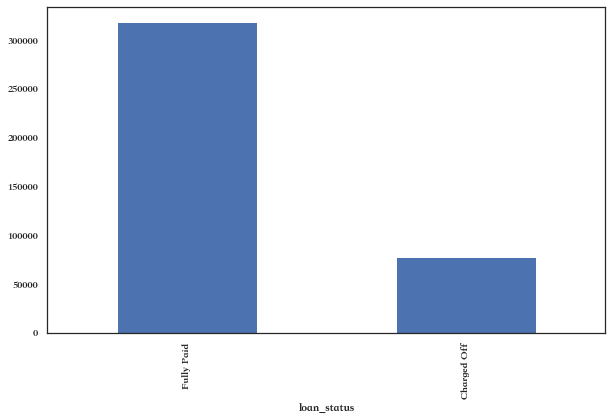

In [52]:
# 目标变量
yflag = 'loan_status'
plt.figure(figsize=(10,6))
df['loan_status'].value_counts(dropna=False).plot.bar()

In [53]:
df['loan_status'] = df['loan_status'].map({'Fully Paid':0,'Charged Off':1})
df['loan_status'].value_counts(dropna=False,normalize=True)

loan_status
0   0.8039
1   0.1961
Name: proportion, dtype: float64

In [54]:
col = df.columns.difference([yflag,'issue_d','address','emp_title','earliest_cr_line','title'])
# 筛选float和int的数值类型变量
num_list = df[col].select_dtypes(include=['float','int64']).columns.tolist()
# 筛选ojbect字符型的数值类型变量
obj_list = df[col].select_dtypes(include=['object']).columns.tolist()
print('数值类型变量共',len(num_list))
print('object类型变量共',len(obj_list))

数值类型变量共 12
object类型变量共 9


## 1.2.对离散特征编码

In [55]:
for c in obj_list:
    le = LabelEncoder()
    le.fit(df[c])
    df[c] = le.transform(df[c])

In [56]:
# 对缺失值填充
df = df.fillna(-9999)

In [57]:
df.head(2)

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0000,0,11.4400,329.4800,1,8,Marketing,1,5,117000.0000,...,16.0000,0.0000,36369.0000,41.8000,25.0000,1,1,0.0000,0.0000,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0000,0,11.9900,265.6800,1,9,Credit analyst,4,1,65000.0000,...,17.0000,0.0000,20131.0000,53.3000,27.0000,0,1,3.0000,0.0000,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"


# 2.决策树自动挖掘规则

DecisionTreeClassifier参数介绍：

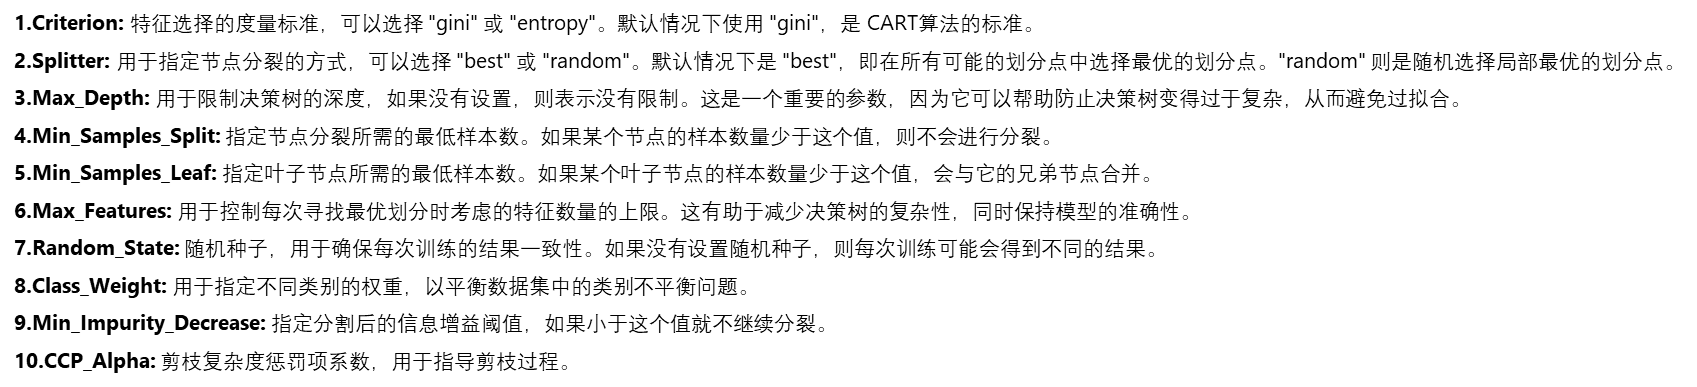

## 2.1.构建决策树模型

In [58]:
X = df[df.columns.difference([yflag,'issue_d','address','emp_title','earliest_cr_line','title'])]
y = df[yflag]

# 划分数据集
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

# 按照最优的方式分裂
model=tree.DecisionTreeClassifier(criterion="gini",
                                  splitter='best',
                                  random_state=42,
                                  max_depth=3,
                                  min_samples_leaf=0.05,
                                  min_samples_split=0.05)
model = model.fit(x_train,y_train)

## 2.2. 自动挖掘多变量规则

In [59]:
# 输出每条决策树规则对应的最终预测值函数
def predict_value(tree):
    """
    :param tree: 决策树对象
    :return: 返回节点评估指标的列表
    """
    value_list = []
    tree_ = tree.tree_
    def recurse(node, depth):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            recurse(tree_.children_left[node], depth + 1)
            recurse(tree_.children_right[node], depth + 1)
        else:
            # 提取value中的正负样本
            good = tree_.value[node][0][0]
            bad  = tree_.value[node][0][1]
            samples = good+bad
            # 计算坏账率badrate
            bad_rate = round(bad*100/(bad+good),4)
            hit_rate = round(samples*100/total_sample,4)
            recall_rate = round(bad*100/total_bad,4)
            lift = round(bad_rate*0.01/total_badrate,4)
            
            value_list.append([bad_rate,hit_rate,recall_rate,lift])
    recurse(0, 1)
    return value_list

# 决策树规则抽取和解析函数
def extract_tree_rules(tree, feature_names):
    """
    :param tree:             决策树对象
    :param feature_names:    构建决策树使用的特征名称
    :return:                 决策树规则抽取结果
    """
    left = tree.tree_.children_left
    right = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features = [feature_names[i] for i in tree.tree_.feature]
    index_list = np.argwhere(left == -1)[:, 0]
    value_list = predict_value(tree)
    rule_list = []
    # print(value_list)
    def decision_flow_extract(left, right, child, d_flow=None):
        """
        :param left:    数组格式，决策树左子节点id
        :param right:   数组格式，决策树右子节点id
        :param child:   子节点id
        :param d_flow:  子节点决策流
        :return:        子节点对应的决策流
        """
        if d_flow is None:
            d_flow = [child]
        if child in left:
            parent = np.where(left == child)[0].item()
            split = 'le'
        else:
            parent = np.where(right == child)[0].item()
            split = 'rg'
        d_flow.append((parent, split, threshold[parent], features[parent]))
        if parent == 0:
            d_flow.reverse()
            return d_flow
        else:
            return decision_flow_extract(left, right, parent, d_flow)
    rule_list=[]
    left_symbol = '<='
    rgiht_symbol = '>'
    for j, child in enumerate(index_list):
        clause = ''
        for node in decision_flow_extract(left, right, child):
            if len(str(node)) < 3:
                continue
            i = node
            if i[1] == 'le':
                sign = left_symbol
            else:
                sign = rgiht_symbol
            clause = clause + i[3] + sign + str(i[2]) + ' and '
        value_list[j].append(clause[:-4])
        # clause = clause[:-4] + ' Badrate:' + str(round(value_list[j],4))
        rule_list.append(value_list[j])
    return rule_list

In [60]:
# 统计样本指标
total_bad = y.sum()
total_badrate = y.mean()
total_sample = y.count()

# 调用决策树规则自动抽取函数进行规则抽取和解析
rule_d = extract_tree_rules(tree=model, feature_names=X.columns.tolist())

# 输出抽取和解析的决策树规则
rule_df = pd.DataFrame(rule_d,columns=['bad_rate','hit_rate','recall_rate','lift','rule_name'])
# 定义颜色
cm = sns.light_palette("red", as_cmap=True)
rule_df.sort_values('bad_rate',ascending=False).style.background_gradient(cmap=cm)
# .style.highlight_max(subset=rule_df.columns.difference(['rule_name']), axis=0)

,bad_rate,hit_rate,recall_rate,lift,rule_name
7,45.992400,4.054500,9.507800,2.345000,sub_grade>11.5 and sub_grade>19.5 and dti>20.795000076293945
6,34.684100,5.296300,9.366200,1.768400,sub_grade>11.5 and sub_grade>19.5 and dti<=20.795000076293945
5,32.514700,6.765600,11.216300,1.657800,sub_grade>11.5 and sub_grade<=19.5 and dti>23.704999923706055
4,23.783200,18.111500,21.962600,1.212600,sub_grade>11.5 and sub_grade<=19.5 and dti<=23.704999923706055
3,19.306100,7.517900,7.400300,0.984400,sub_grade<=11.5 and sub_grade>6.5 and dti>21.074999809265137
2,13.879700,16.791700,11.883200,0.707700,sub_grade<=11.5 and sub_grade>6.5 and dti<=21.074999809265137
1,9.759200,12.183900,6.062600,0.497600,sub_grade<=11.5 and sub_grade<=6.5 and sub_grade>3.5
0,5.382900,9.278600,2.546600,0.274500,sub_grade<=11.5 and sub_grade<=6.5 and sub_grade<=3.5


## 2.3. 制定规则

**规则：(sub_grade>19.5)&(dti>20.795)**

评估指标：
- badrate=45.99%
- lift=39.02%/19.61%=2.34
- hitrate=4.05%
- recall_rate=9.51%

# 番外

如果对pandas不熟悉想要进阶的朋友可以了解下东哥的这个原创笔记，已经完全体，后续随着版本迭代会持续更新。

[《pandas进阶宝典》](https://app7hmmvkwr2019.h5.xiaoeknow.com/p/course/ecourse/course_2YD5u0x8FzrAIyM8soEuxnTkP9r)永久访问权限，500页图文笔记，近30万字，配套完整代码支持下载。

5大核心图文，具体包括：
- 《pandas快速入门》
- 《pandas进阶宝典》
- 《pandas实战项目》
- 《pandas进阶题库》
- 《Numpy速查手册》
- 《正则表达式手册》

感兴趣可以扫码了解，或者加我微信可以有折扣，加V：`Petery_1966`

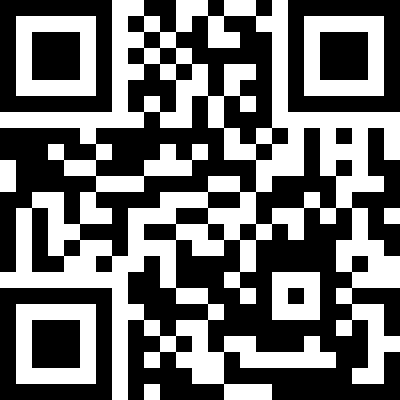